In [1]:
#abtem version: 7a663e35aea0aa787257840f232dcaee4a734ae7
import os
#os.environ["MKL_NUM_THREADS"] = "16"
#os.environ["NUMEXPR_NUM_THREADS"] = "16"
#os.environ["OMP_NUM_THREADS"] = "16"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *
from abtem.utils import GaussianDistribution
from ase.io import read
from ase.build import surface, bulk
from tqdm.auto import tqdm
from ase.build import graphene

from tqdm.auto import tqdm
from abtem.structures import orthogonalize_cell
from abtem.measure import center_of_mass

In [3]:
from ase.build import nanotube

In [4]:
from abtem.detect import AnnularDetector
from abtem.noise import poisson_noise
import scipy.constants as c
from scipy.optimize import minimize
from collections import defaultdict
from abtem.scan import PositionScan
from abtem.custom import get_gaussian_spread
from abtem.reconstruct import invms

from abtem.noise import poisson_noise
import scipy.constants as c
from abtem.measure import bandlimit
from abtem.custom import get_radiation_dose

from abtem.custom import incoherent_scan
from abtem.waves import _multislice
import cupy as cp
from abtem.custom import incoherent_scan_mc
from abtem.custom import incoherent_probe, get_probe_radius
from abtem.custom import sample_probe
from abtem.custom import incoherent_scan_mc_fp

In [5]:
import py4DSTEM

In [6]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (10, 10)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
                'size'   : 15}
matplotlib.rc('font', **font)

In [7]:
def get_potential(atoms_in,extent,sampling): # lepsi je v projects/14_tf/test_parallax.ipynb
    atoms=atoms_in.copy()
    atoms_extent=atoms.cell.diagonal() #x,y,z
    
    vacuum=(extent-atoms_extent)/2 #x,y,z
    
    atoms.center(vacuum=vacuum[0],axis=(0))
    atoms.center(vacuum=vacuum[1],axis=(1))
    
    potential_p = Potential(FrozenPhonons(atoms, sigmas=.06, num_configs=1), #atoms_tot_p,
                      sampling=sampling,
                      #gpts=round(extent/sampling),
                      slice_thickness=2,
                      projection='infinite',
                      parametrization='kirkland')
    return potential_p

# Partial coherence in 4D-STEM

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


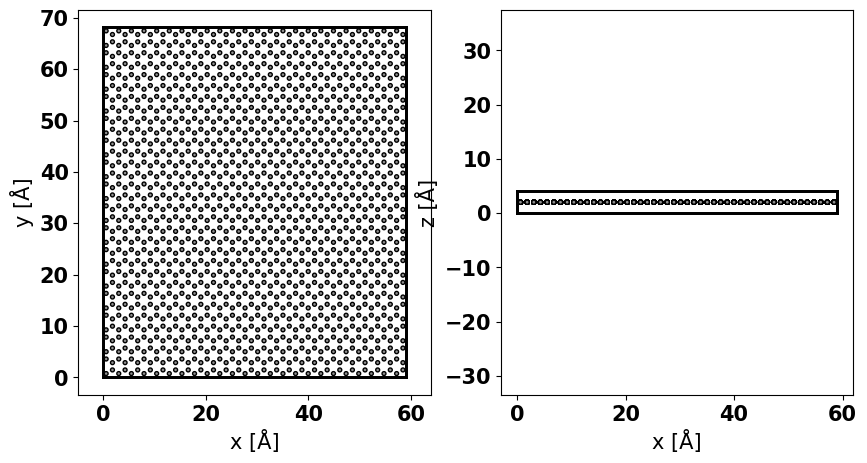

In [8]:
atoms = graphene()
atoms = orthogonalize_cell(atoms)
atoms *= (24,16,1)

atoms.center(vacuum=2, axis=2)
atoms.center()

fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='xz');

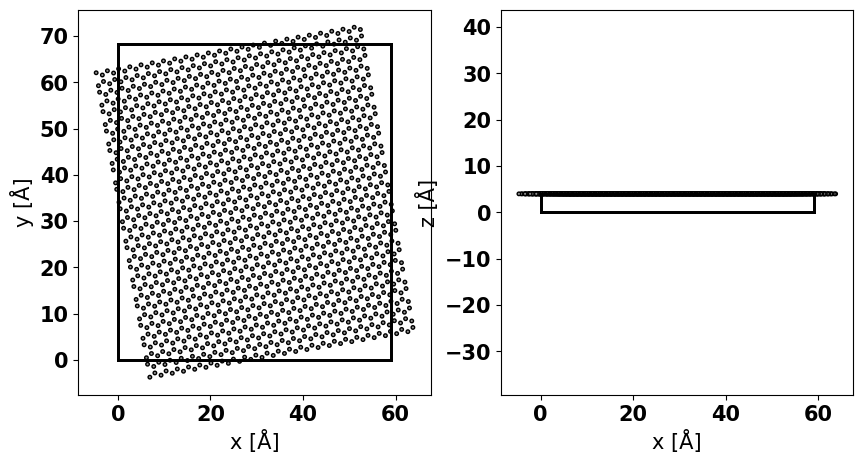

In [9]:
atoms_rotated=atoms.copy()
atoms_rotated.rotate(10,"z")
atoms_rotated.center()
atoms_rotated.positions+=np.array([0,0,2])
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms_rotated, ax=ax1)
show_atoms(atoms_rotated, ax=ax2, plane='xz');

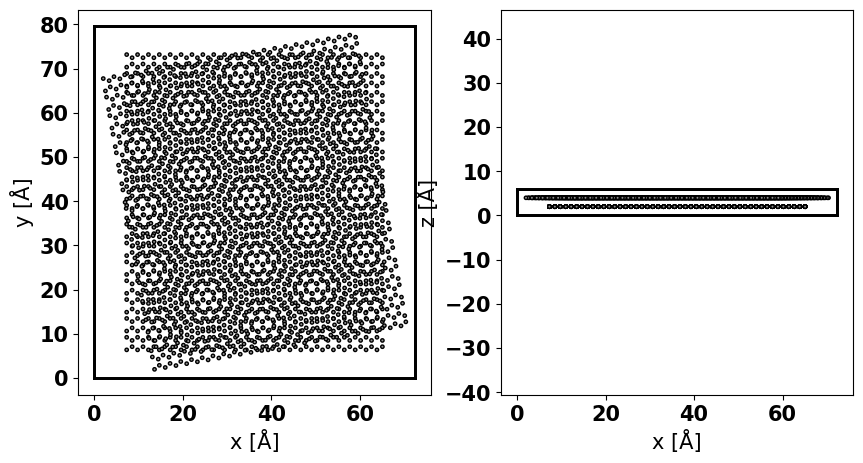

In [10]:
atoms_moire=atoms+atoms_rotated
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
atoms_moire.center(vacuum=2)

show_atoms(atoms_moire, ax=ax1)
show_atoms(atoms_moire, ax=ax2, plane='xz');

<Axes: xlabel='x [Å]', ylabel='y [Å]'>

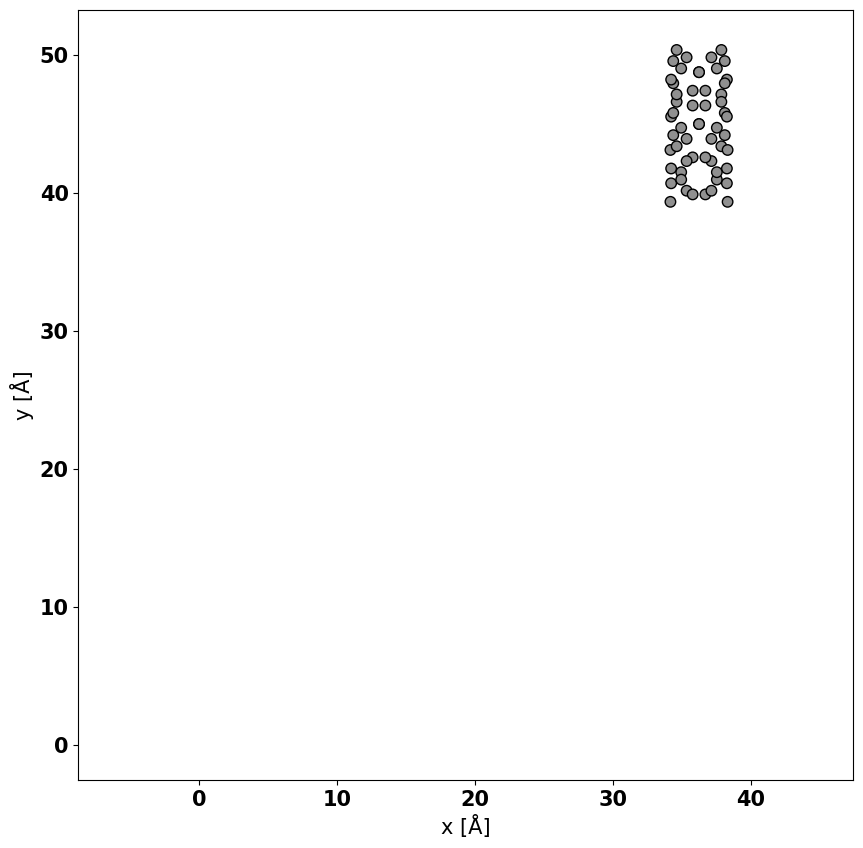

In [11]:
cnt = nanotube(5, 4, length=1)
cnt.rotate(90,"y",center='COM')
cnt.center(vacuum=1,about=0)
#show_atoms(cnt,plane="xz")
cnt.translate(-cnt.get_center_of_mass()+atoms_moire.get_center_of_mass()+np.array([0,0,3.9]))

cnt2=cnt.copy()
cnt2.rotate(30,"z",center='COM')

cnt3 = nanotube(2, 4, length=1)
cnt3.translate(-cnt3.get_center_of_mass()+atoms_moire.get_center_of_mass()+np.array([0,5,3.9]))
cnt3.rotate(90,"x",center='COM')
#cnt3.rotate(60,"z",center='COM')
show_atoms(cnt3,plane="xy")

<Axes: xlabel='x [Å]', ylabel='y [Å]'>

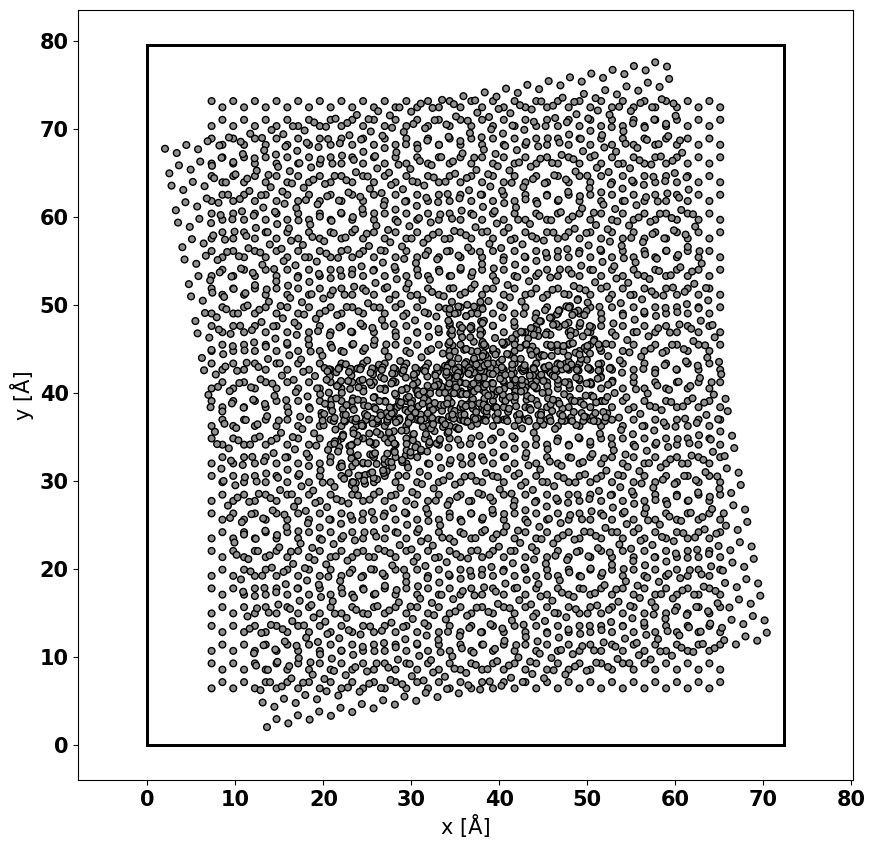

In [12]:
atoms_tot=atoms_moire+cnt+cnt2+cnt3
atoms_tot.center(vacuum=2)
show_atoms(atoms_tot)

In [13]:
energy = 30e3

energy_spread = 0.6
Cc = 1.34e-3/1e-10
focal_spread = energy_spread/energy * Cc # 1/e width of focal distribution
temporal_sigma = focal_spread/np.sqrt(2) # std of focal distribution (normal distribution is proportional to e**( 1/2*(x/std)**2) )
B_r=1e8

#px_size = 1
px_num = 256
#camera_length = 240e-3
#angular_sampling = px_size/camera_length*1e3 # in mrad
angular_semiextent = 60
                                                                                                                                                                                                                                                                                                                               
binning = 1
reciprocal_oversampling = 1
direct_oversampling = 4
import abtem.custom
sampling_repro,extent_repro = abtem.custom.semiangle_2_sampling_extent(angular_semiextent,px_num/binning,energy=energy,direct_oversampling=direct_oversampling,reciprocal_oversampling=reciprocal_oversampling)

semiangle_cutoff = 12.4
aberrations = {
    'defocus': 400,
    'C30': 0.88e-3/1e-10,
    'C50': 0.81e-3/1e-10}

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fdbdfd13070>)

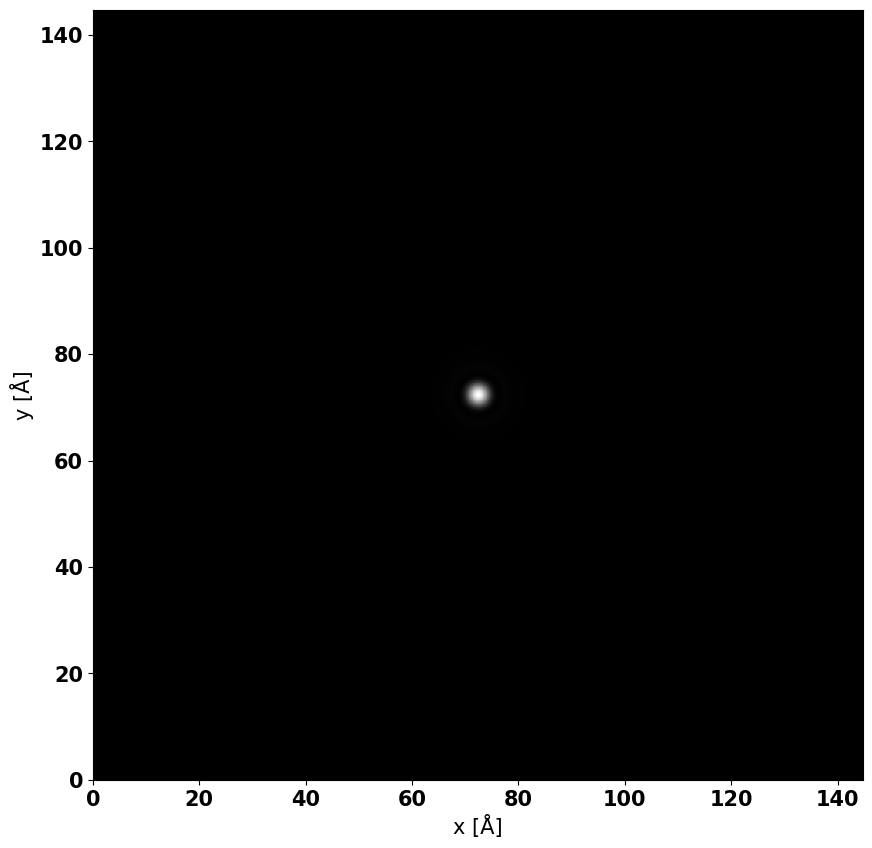

In [14]:
#probe = SMatrix(energy=energy,interpolation=1,semiangle_cutoff=semiangle_cutoff, expansion_cutoff=semiangle_cutoff*2+0.5,**aberrations, device='gpu')
potential = get_potential(atoms_tot,extent_repro,sampling_repro)
probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff,**aberrations, device='gpu')
#potential = Potential(FrozenPhonons(atoms_tot, sigmas=.06, num_configs=1), #atoms,
#                      sampling=.1,
#                      slice_thickness=0.25,
#                      projection='infinite',
#                      parametrization='kirkland')

probe.grid.match(potential)

#probe.build().collapse().show();
probe.show()

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

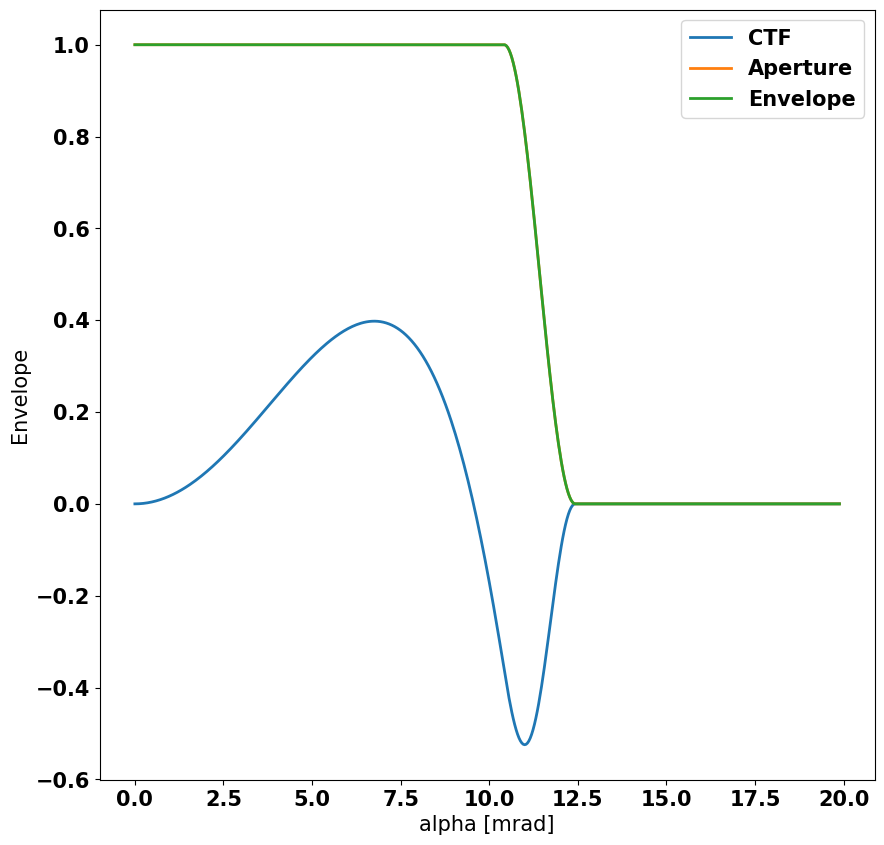

In [15]:
probe.ctf.show()

In [16]:
probe.ctf.nyquist_sampling*0.9

1.2663656029078592

In [17]:
scan_sampling = 1.2
scan = GridScan((potential.extent[0]*0.5/10,potential.extent[0]*0.5/10), (potential.extent[1]*9.5/10, potential.extent[1]*9.5/10), sampling = scan_sampling)
detector = PixelatedDetector()
detector_segmented = SegmentedDetector(0,semiangle_cutoff*1.5,1,4)

In [18]:
print(potential.extent)
print(potential.gpts)

(144.8870729581744, 144.8870729581744)
(996, 996)


In [19]:
10/33.8

0.2958579881656805

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fdbe5a666e0>)

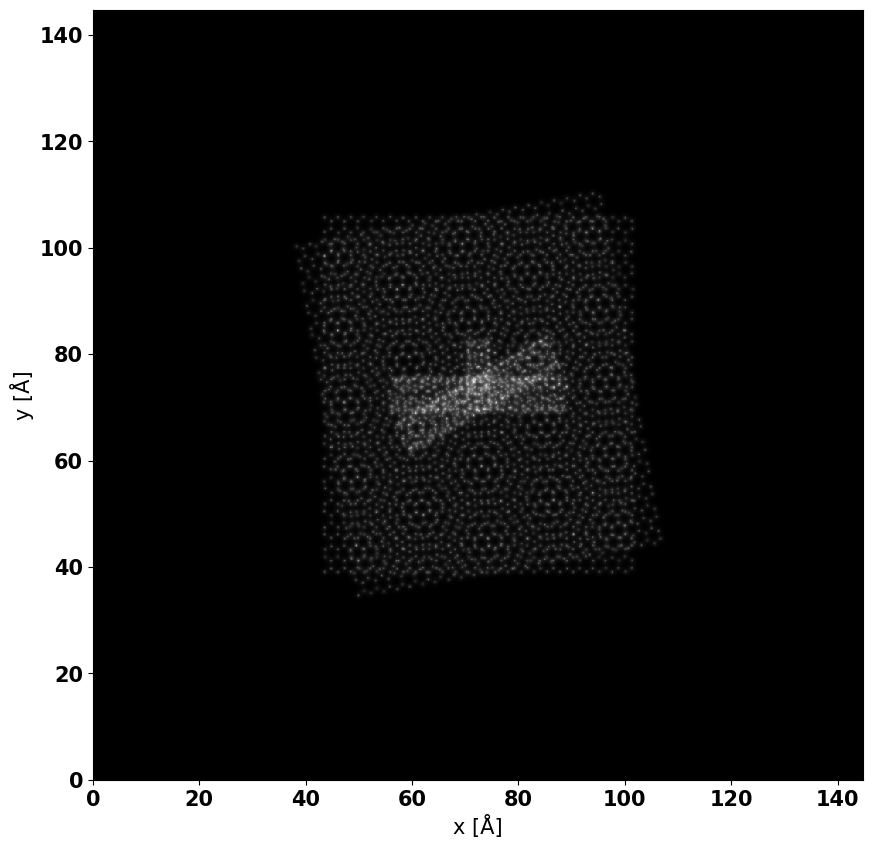

In [20]:
potential.build().project().show()

In [21]:
f=2
(potential.extent[0]*(5-f)/10,potential.extent[0]*(5-f)/10), (potential.extent[1]*(5+f)/10, potential.extent[1]*(5+f)/10)

((43.466121887452324, 43.466121887452324),
 (101.42095107072208, 101.42095107072208))

In [22]:
#S=probe.multislice(potential,pbar=True)
#S=S.downsample()

In [23]:
#measurement,measurement_segmented = probe.scan(scan, [detector,detector_segmented], potential, pbar=True)
#measurement_segmented = probe.scan(scan, detector_segmented, potential, pbar=True)
from abtem.detect import FlexibleAnnularDetector
measurement = probe.scan(scan, detector, potential, pbar=True,max_batch=200)
#measurement,measurement_segmented = S.scan(scan, [detector], pbar=True)

#from abtem.device import copy_to_device
#from abtem.waves import SMatrixArray
#import cupy as cp
#try:
#    del S_gpu
#except:
#    print("nope")
##S_gpu=S.transfer("gpu")
#S_gpu = SMatrixArray(array=cp.array(copy_to_device(S.array, "gpu")),                                                        
#                              k=S.k.copy(),                                                                                 
#                              ctf=S.ctf.copy(),                                                                             
#                              extent=S.extent,                                                                              
#                              offset=S.offset,                                                                              
#                              interpolated_gpts=S.interpolated_gpts,                                                        
#                              energy=S.energy,                                                                              
#                              antialias_aperture=S.antialias_aperture,                                                      
#                              device="gpu")  
#
#measurement,measurement_segmented = S_gpu.scan(scan, detector, pbar=True)

Potential:   0%|          | 0/6 [00:00<?, ?it/s]

Scan:   0%|          | 0/11881 [00:00<?, ?it/s]

In [24]:
%%time

I_reg=50e-12 
el=I_reg*1e-5/c.e 
pixel_area=1 #effectively disabled 
measurement_crop=abtem.custom.crop(measurement,extent=(angular_semiextent*2,angular_semiextent*2))
measurement_noisy = poisson_noise(measurement_crop/np.mean(np.sum(measurement.array,(-2,-1))), dose=el,pixel_area=pixel_area)/el


CPU times: user 32.1 s, sys: 37.4 s, total: 1min 9s
Wall time: 1min 9s


In [25]:
el*len(scan.get_positions())/np.prod(scan.extent)

2180.5613498777825

In [26]:
#annular_detector=AnnularDetector(inner=20,outer=150)
annular_detector=AnnularDetector(inner=12.5,outer=59)
ress=annular_detector.integrate(measurement_noisy)

In [27]:
el

3120.7545372303816

In [28]:
50e-12*1e-3/c.e

312075.45372303814

(<Axes: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fdbdf9a5330>)

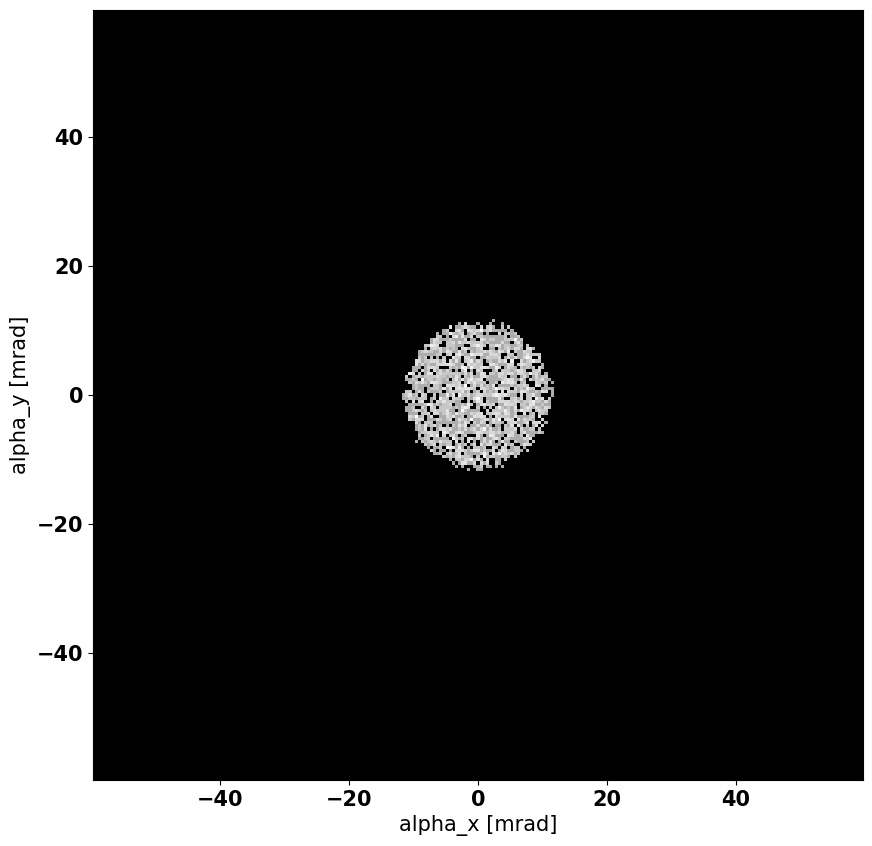

In [29]:
#%matplotlib widget
measurement_noisy[0,0].show(power=0.2)

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fdbdf804730>)

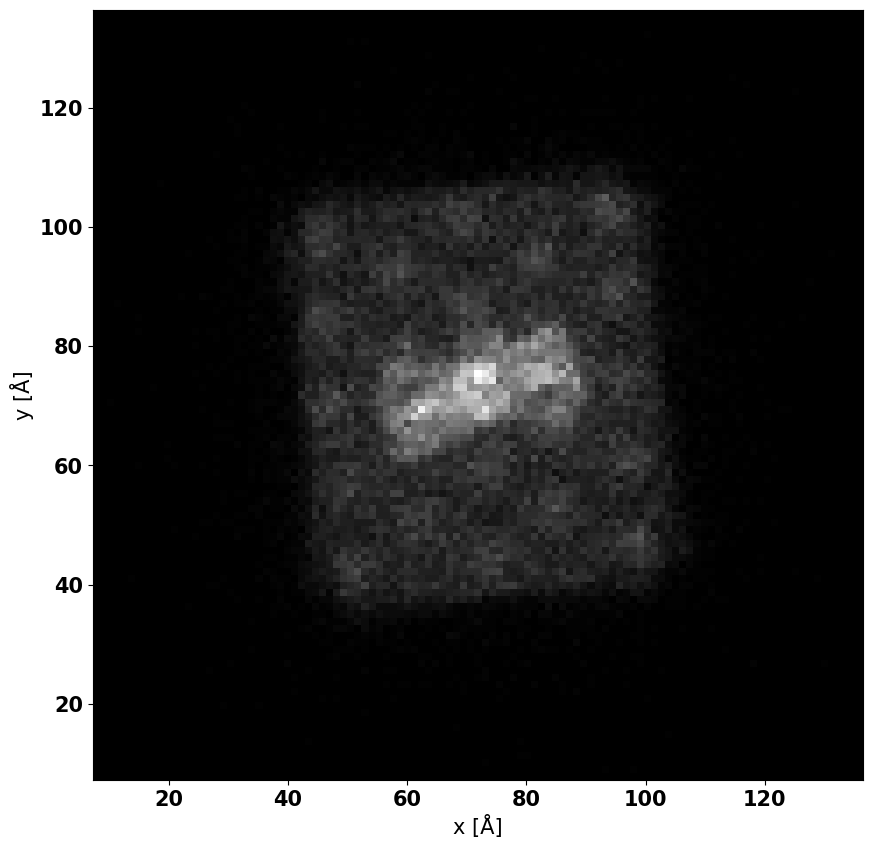

In [30]:
ress.show()

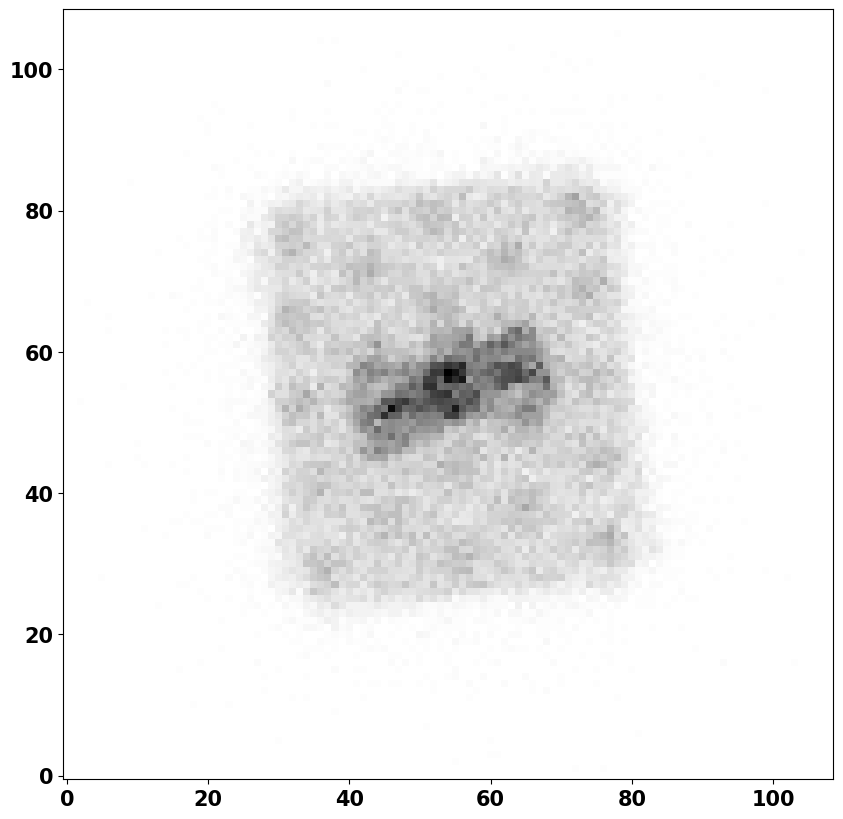

In [31]:
plt.figure()
plt.imshow(-ress.array.T,origin="lower",cmap="gray")

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fdbdfdd14e0>)

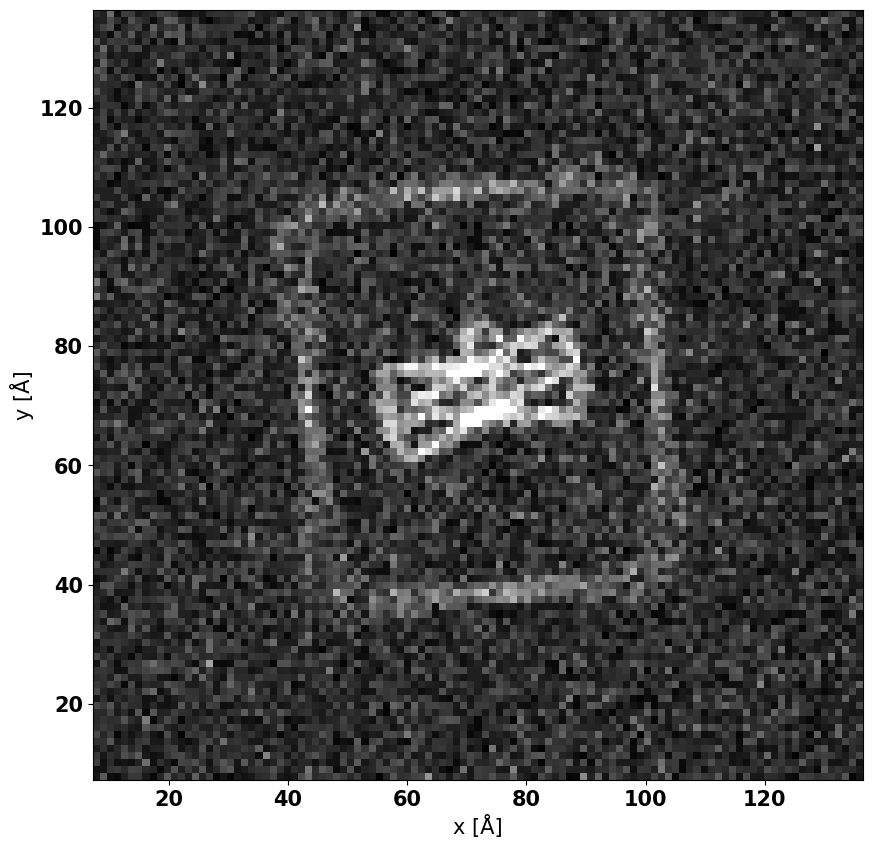

In [32]:
com = center_of_mass(measurement_noisy, return_magnitude=False)



cmap = 'gray'
com_mag=com[0].copy()
com_mag.array=np.sqrt(com[0].array**2+com[1].array**2)
com_mag.show(cmap=cmap, vmin=0, vmax=.7)

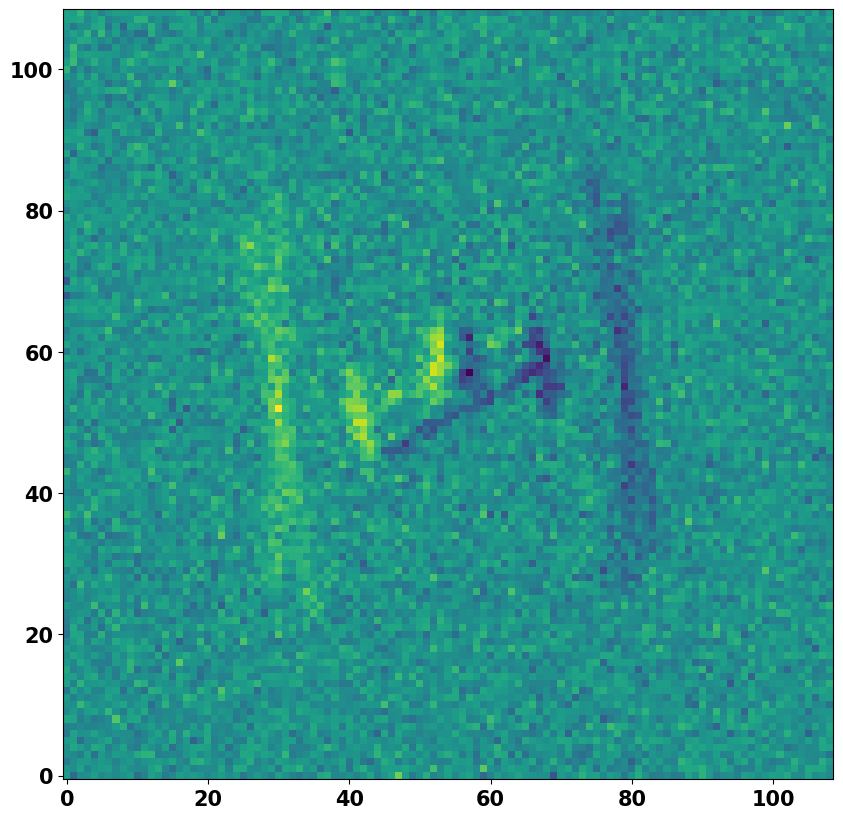

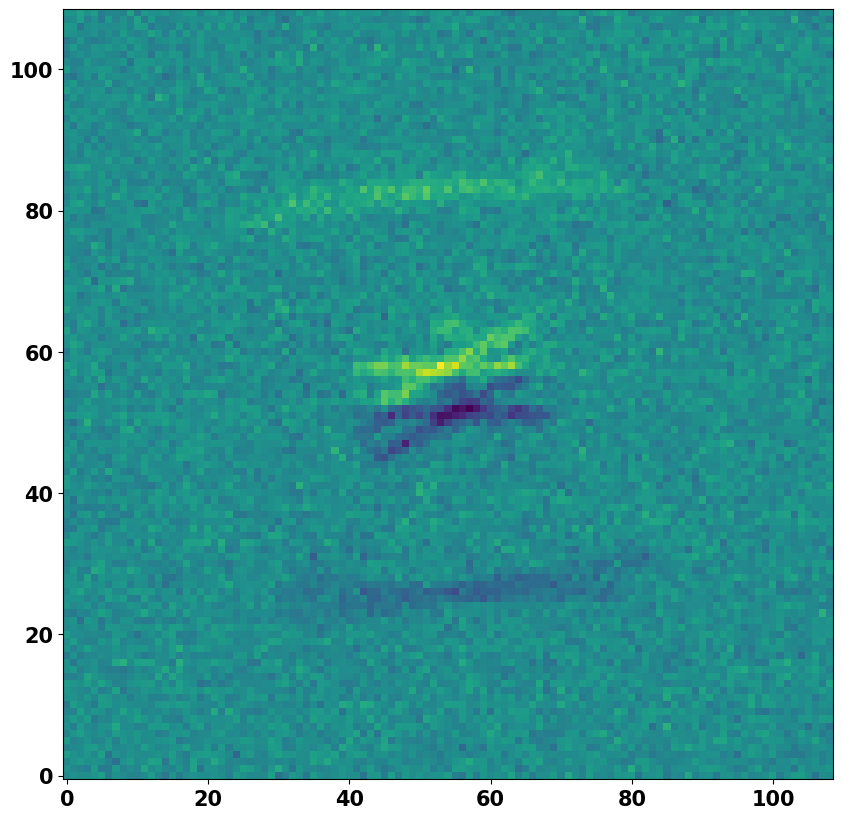

In [33]:
plt.figure()
plt.imshow(com[0].array.T,origin="lower")
plt.figure()
plt.imshow(-com[1].array.T,origin="lower")

In [34]:
#%matplotlib widget

In [35]:
dataset = py4DSTEM.DataCube(
    data=measurement_noisy.array,
)
dataset

DataCube( A 4-dimensional array of shape (109, 109, 249, 249) called 'datacube',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [36]:
dataset.calibration.set_R_pixel_size(scan_sampling)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(probe.angular_sampling[0])#semiangle_cutoff / probe_radius_pixels)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.4816911239396083
             R_pixel_size:    1.2
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

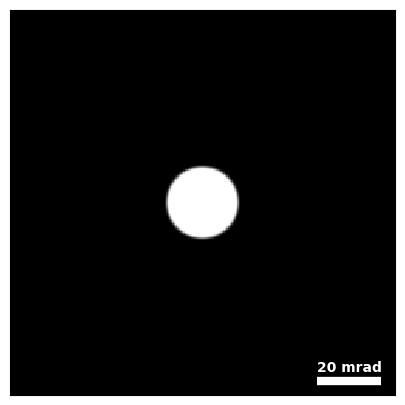

In [37]:
dataset.get_dp_mean();
py4DSTEM.show(
    dataset.tree('dp_mean'),
    ticks=False
)

In [38]:
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size()

print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

Estimated probe radius = 23.12 pixels


Best fit rotation = -3 degrees.


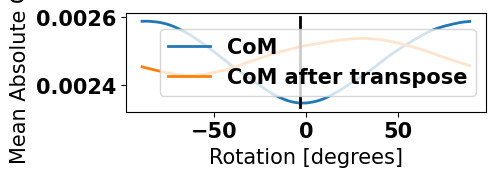

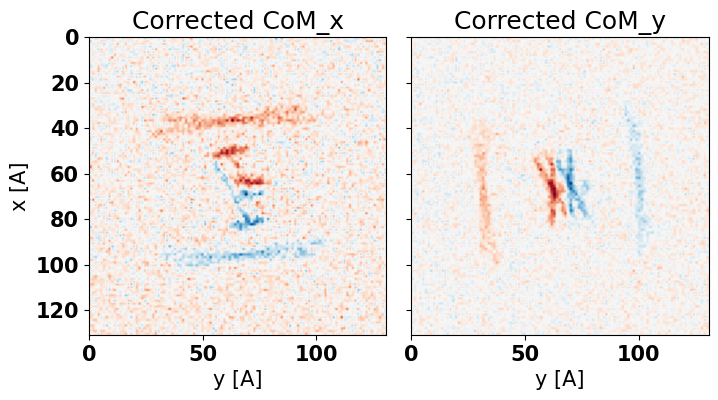

In [39]:
dpc = py4DSTEM.process.phase.DPC(
    datacube=dataset,
    energy=energy,
    verbose=True,
).preprocess()

In [40]:
dpc._com_measured_x

array([[124.100914, 124.019966, 123.67605 , ..., 124.07089 , 124.182724,
        124.198814],
       [123.49043 , 123.94233 , 123.951385, ..., 123.6636  , 124.18961 ,
        124.12872 ],
       [123.921234, 124.19025 , 124.08716 , ..., 123.94756 , 124.26961 ,
        124.45374 ],
       ...,
       [123.89956 , 124.24259 , 123.843636, ..., 123.945724, 124.07456 ,
        124.20311 ],
       [124.01466 , 124.237625, 124.33001 , ..., 124.082115, 124.00192 ,
        123.73549 ],
       [123.88611 , 123.93048 , 124.097046, ..., 123.81692 , 124.25032 ,
        124.12033 ]], dtype=float32)

In [41]:
np.linalg.norm([1,1])

1.4142135623730951

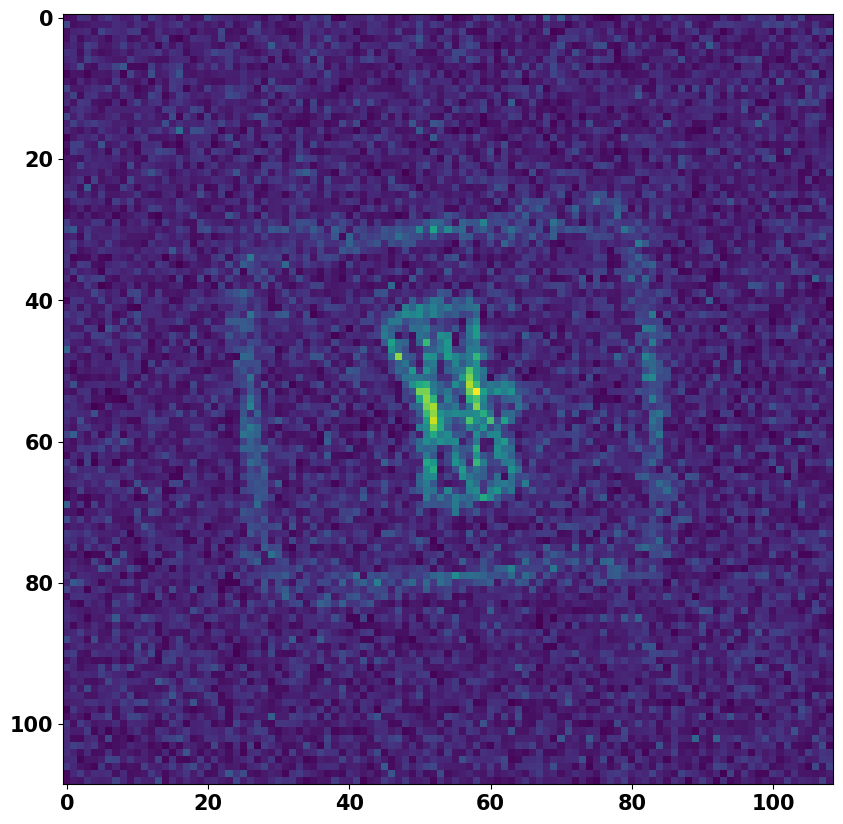

In [42]:
plt.figure()
plt.imshow(np.sqrt(dpc._com_x**2+dpc._com_y**2))

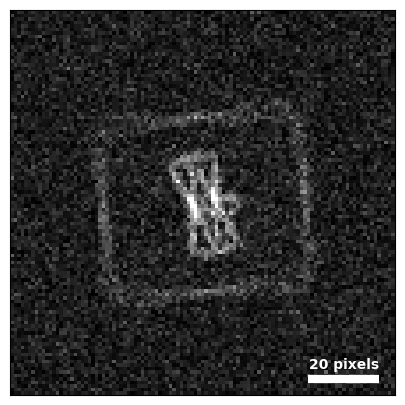

In [43]:
py4DSTEM.show(
    np.linalg.norm([dpc._com_x,dpc._com_y],axis=0),
    cmap='gray',
    vmin=0.01,
    vmax=0.999,
    ticks=False,
    scalebar=True,
)

Reconstructing phase:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 27/32 [00:00<00:00, 180.04 iter/s]
Step-size has decreased below stopping criterion 1e-06.


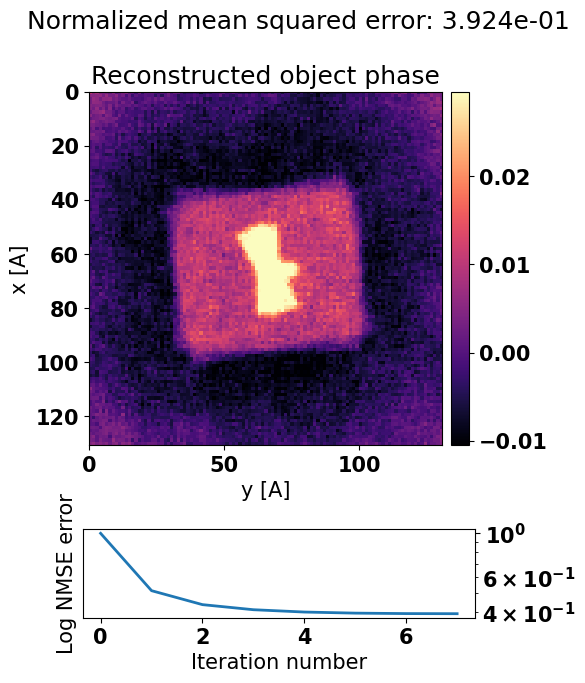

In [44]:
dpc.reconstruct(
    max_iter=32,
    reset=True,
#    q_highpass=0.02,
    gaussian_filter_sigma = 0.375, # in pixels since we haven't calibrated
).visualize(
    figsize=(6,7),
    cbar=True,
    #vmax=
);

In [46]:
scan_extent= (0,scan.extent[0],0,scan.extent[1])

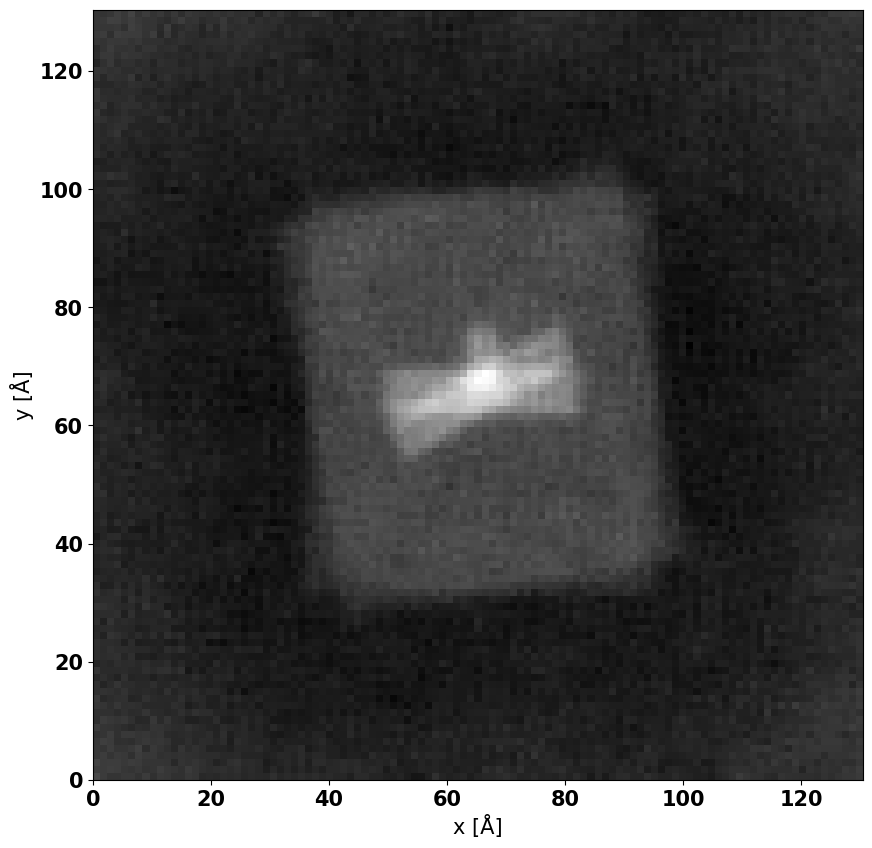

In [51]:
plt.figure()
plt.imshow(dpc.object_phase.T,extent=scan_extent,origin="lower",cmap="gray")
plt.xlabel("x [Å]")
plt.ylabel("y [Å]")
plt.savefig("figs_icom/icom_phase.pdf")

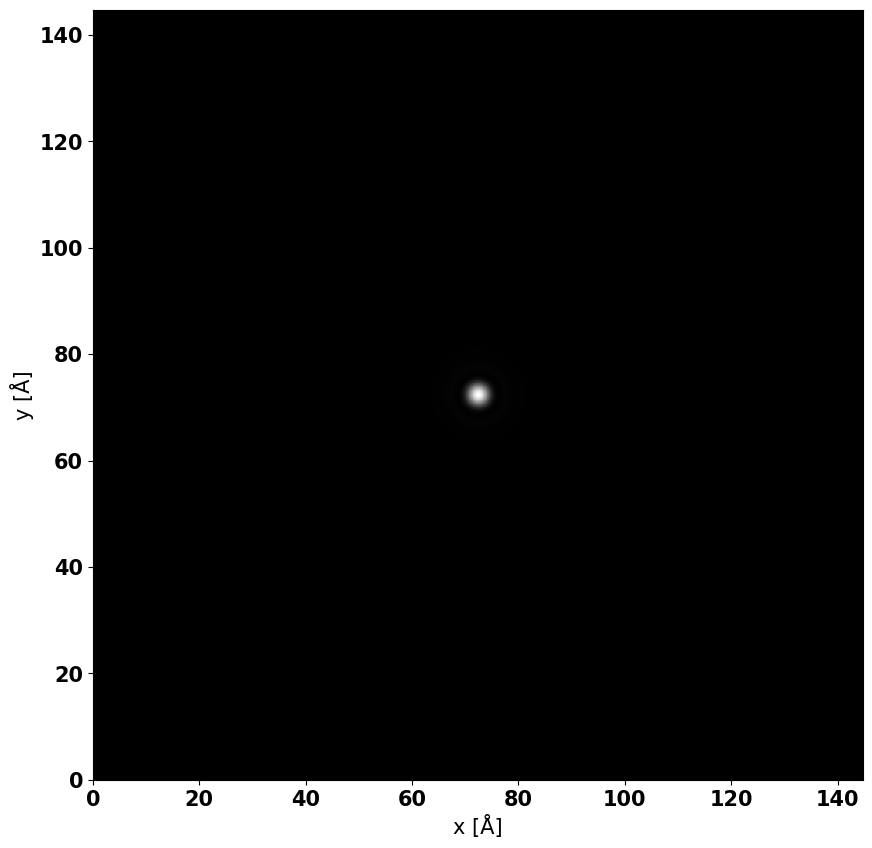

In [55]:
probe.show()
plt.savefig("figs_icom/icom_probe.pdf")